In [ ]:
# @title
from IPython.display import HTML

# HTML y CSS para el título y la imagen en Google Colab
html_code = """
<style>
  #container {
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 10px;
  }

  #title {
    font-size: 50px;
    font-weight: bold;
    color: black;
  }

  #logo {
    width: 174px;
    height: 101.5px;
  }
</style>

<div id="container">
  <div id="title">SunScan</div>
  <img id="logo" src="https://www.valoraanalitik.com/wp-content/uploads/2023/10/bid-696x406.jpg" alt="Logo">
</div>
"""

# Mostrar el código HTML en Colab
display(HTML(html_code))


In [ ]:
#@title 1. Configurar ambiente
%%time

!git clone https://github.com/sesaga478/SolarEnergy_From_Satellite
%cd '/content/SolarEnergy_From_Satellite'
!pip install --user -r requirements.txt

#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

#Gestionar archivos zip dentro del repositorio
import zipfile
import glob

split_zip_files = glob.glob('/content/SolarEnergy_From_Satellite/data_example/images/*.zip.0*')
split_zip_files.sort()

output_zip_path = '/content/image.zip'
with open(output_zip_path, 'wb') as output_zip:
    for split_file in split_zip_files:
        with open(split_file, 'rb') as input_part:
            output_zip.write(input_part.read())

#Extrar contenido del nuevo archivo zip
with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/SolarEnergy_From_Satellite/data_example/images/')



Reiniciar entorno de ejecución

In [ ]:
#@title 2. Cargar dependencias

import os,glob, sys

fol_sys='/content/SolarEnergy_From_Satellite/scripts'
if fol_sys not in sys.path:
    sys.path.append(fol_sys)

from samgeo.text_sam import LangSAM
import leafmap
import shp_down_bb as sdb
import city_from_coord as cfc
import ultimo_archivo as ua
import sunlight_hours as sunh
import solar_energy_shp as ses
import datetime

sam = LangSAM()

In [ ]:
#@title 3. Escoger un área sobre el mapa para realizar el análisis

m_bb=leafmap.Map()
m_bb.add_basemap("Google Satellite")
m_bb

In [ ]:
#@title 4. Descargar la imagen



bb=m_bb.user_roi_bounds()
north, south, east, west = bb[3], bb[1], bb[2], bb[0]
lat,lon=((north+south)/2),((east+west)/2)#Centroid

#Get name of the city with coordinates
city=cfc.city_from_coord(latitude=lat, longitude=lon)
city_name=str(city).replace("'",'').replace('(','').replace(')','').replace(', ','_').replace(' ','').replace('/','')

z=20
image = '/content/'+city_name+'_z{}.tif'.format(str(z))
leafmap.tms_to_geotiff(image, bb, zoom=z, source='Satellite')

In [ ]:
#@title 5. Visualizar las imágenes

path='/content'
palabra_clave='.tif'
img_in=ua.ultimo_archivo(path, palabra_clave)

m0=leafmap.Map()
m0.add_raster(img_in)
m0

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

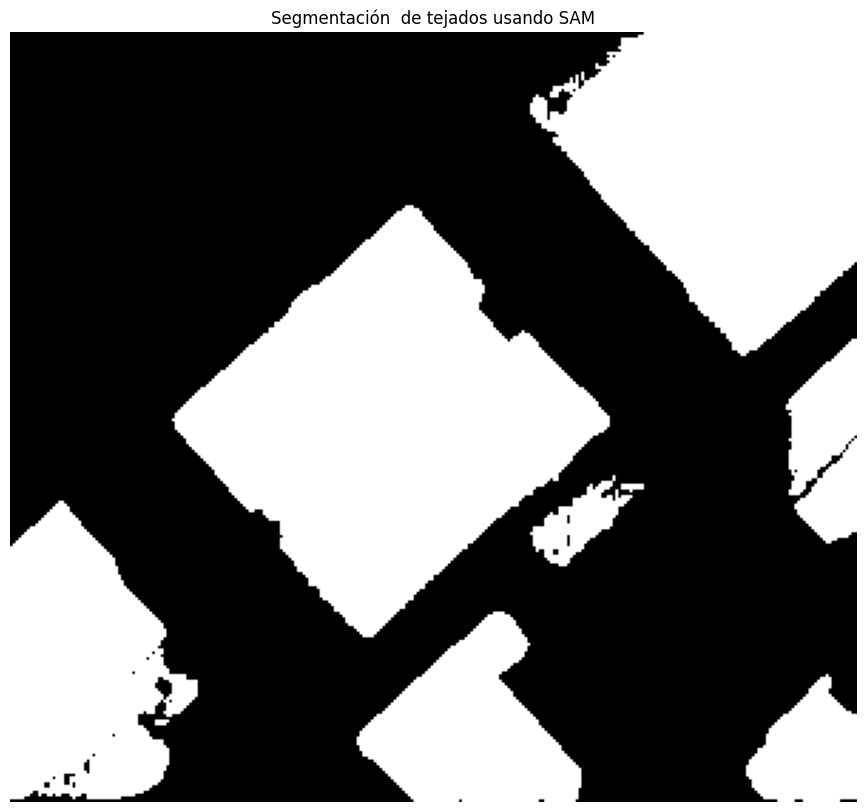

In [20]:
#@title 6. Usar SAM para detectar los tejados
text_prompt='house'

sam.predict(img_in, text_prompt, box_threshold=0.24, text_threshold=0.24)

#Crear el raster
tif_out=img_in.replace('.tif','_sam_{}.tif'.format(text_prompt))
sam.show_anns(  cmap='Greys_r',  add_boxes=False,  alpha=1,
  #title='Segmentation of {}'.format(text_prompt),
  title='Segmentación  de tejados usando SAM', blend=False,  output=tif_out)

#Crear el shp
shp_out=tif_out.replace('.tif','.shp')
sam.raster_to_vector(tif_out,shp_out)

m1=leafmap.Map()
m1.add_raster(img_in)
m1.add_vector(shp_out)
m1

In [21]:
#@title 7. Estimar Energía solar

palabra_clave='.shp'
shp_in=ua.ultimo_archivo(path, palabra_clave)
shp_out=shp_in.replace('.shp','_ener.shp')
excel_out=shp_in.replace('.shp','.xlsx')

start = datetime.datetime(2023, 1, 1, 0, 0, 0)
end = datetime.datetime(2023, 12, 31, 0, 0, 0)

delta = end - start
lon,lat=-70.3197029876276, 8.59742892725757
lon,lat=-75.335938,6.175593

panel_size=4
area_disp=0.5
factor_dim=0.8
panel_pot=0.4

#sunh.sunlight_hours(lat,lon,start,end,excel_out)
ses.solar_energy_shp(shp_in,shp_out,start,end,panel_size,area_disp,factor_dim,panel_pot,excel_out)

msol=leafmap.Map()
msol.add_raster(img_in)
msol.add_vector(shp_out)
msol



Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [23]:
#@title 8. Exportar el resultado (zip con todos los resultados)

